## 1. 필요 정보 임포트 및 시드 고정

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from glob import glob
import cv2
from tqdm import tqdm
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from efficientunet import *
from torch.optim import lr_scheduler, Adam, SGD
from torchvision.models.segmentation import deeplabv3_resnet101
from torchsummaryX import summary

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
import pytorch_msssim

def seed_all(seed = 42):
    
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)  # pytorch (both CPU and CUDA)
    np.random.seed(seed)  # for numpy pseudo-random generator
    #random.seed(seed)  # set fixed value for python built-in pseudo-random generator
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    
seed_all()

## 2. 데이터 전처리 및 데이터셋 선언

loading annotations into memory...
Done (t=3.75s)
creating index...
index created!
loading annotations into memory...
Done (t=1.27s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
328 41 53


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 512, 512]) torch.Size([16, 512, 512])
torch.Size([3, 512, 512]) torch.Size([512, 512])


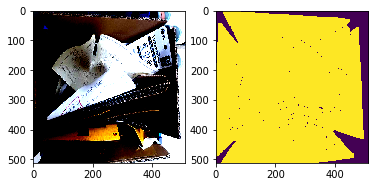

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([512, 512])


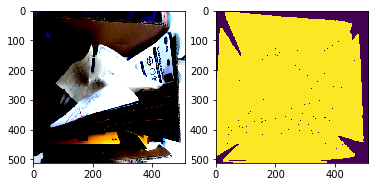

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([512, 512])


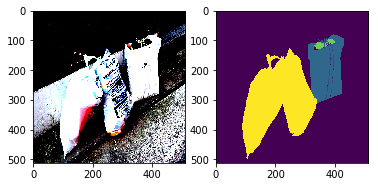

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([512, 512])


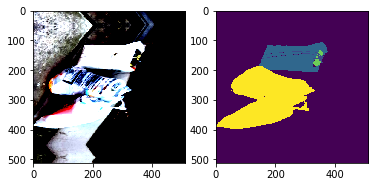

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([512, 512])


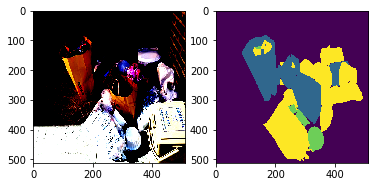

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([512, 512])


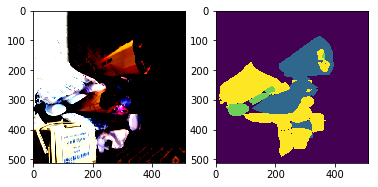

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([512, 512])


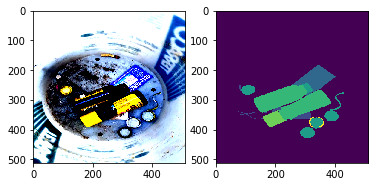

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([512, 512])


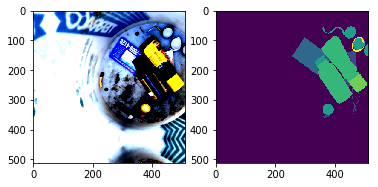

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([512, 512])


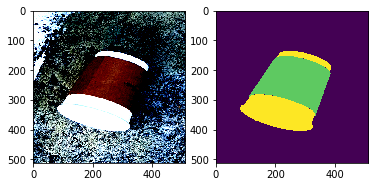

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([512, 512])


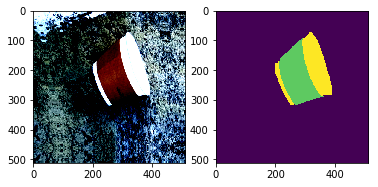

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([512, 512])


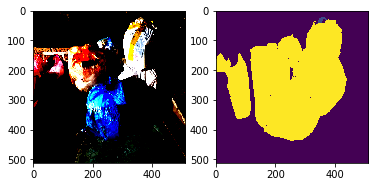

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([512, 512])


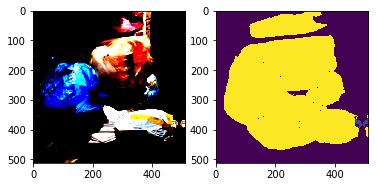

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([512, 512])


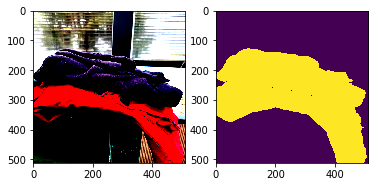

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([512, 512])


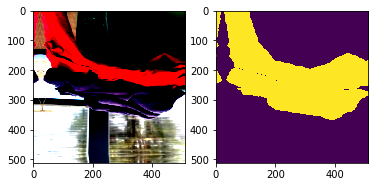

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([512, 512])


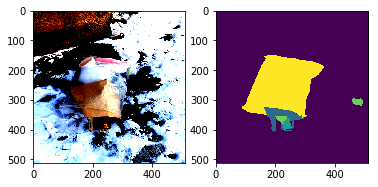

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512]) torch.Size([512, 512])


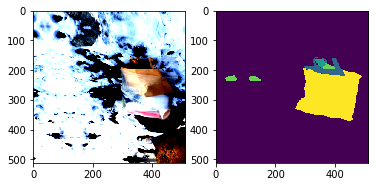

In [2]:
category_names = ["Backgroud","UNKNOWN","General trash","Paper","Paper pack","Metal","Glass","Plastic","Styrofoam","Plastic bag","Battery","Clothing"]
class_nums = len(category_names)

#CLAHE
def clahe_cvt(own_img) :
    lab = cv2.cvtColor(own_img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    cla_img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    return cla_img

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        '''
        self.aug = A.Compose([A.HorizontalFlip(0.5),
                              A.VerticalFlip(0.5),
                              A.RandomRotate90(0.5),
                              ToTensorV2()])
        self.loc_aug = A.Compose([A.HorizontalFlip(p=0.9), 
                                  A.VerticalFlip(p=0.9), 
                                  A.RandomRotate90(p=0.9),
                                  A.OneOf([
                                    A.MotionBlur(p=1),
                                    A.OpticalDistortion(p=1),
                                    A.GaussNoise(p=1),
                                    ], p=1), 
                                  ToTensorV2()])
        self.ela_aug1 = A.Compose([A.ElasticTransform(p=0.9),
                                   A.GridDistortion(p=0.9),
                                   A.OpticalDistortion(p=0.9),
                                   ToTensorV2()])
        '''
        self.ela_aug2 = A.Compose([A.HorizontalFlip(p=0.9), 
                                  A.VerticalFlip(p=0.9), 
                                  A.RandomRotate90(p=0.9),
                                  A.OneOf([
                                    A.MotionBlur(p=1),
                                  #  A.OpticalDistortion(p=1),
                                  #  A.GaussNoise(p=1),
                                    ], p=1),
                                   A.ElasticTransform(p=0.9),
                                   A.GridDistortion(p=0.9),
                                   A.OpticalDistortion(p=0.9),
                                   ToTensorV2()])
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        #CLAHE Convert
        #images = clahe_cvt(images)
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        #images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
                
                if self.mode == 'train' :
                    #loc_img = self.loc_aug(image = images, mask = masks)
                    #ela1_img = self.ela_aug1(image = images, mask = masks)
                    ela2_img = self.ela_aug2(image = images, mask = masks)
                    #aug_img = self.aug(image = images, mask = masks)
                    transformed = A.Compose([ToTensorV2()])(image = images, mask = masks)
                    images = transformed["image"]
                    masks = transformed["mask"]
                
                    images = (images, ela2_img["image"])#, loc_img["image"])#ela1_img["image"], ela2_img["image"])
                    masks = (masks, ela2_img["mask"])#, loc_img["mask"])#ela1_img["mask"], ela2_img["mask"])
                
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())
    
# train.json / validation.json / test.json 디렉토리 설정
dataset_path = 'input/data'
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch): return tuple(zip(*batch))

train_transform = A.Compose([
                            #A.Resize(256, 256),
                            #A.HorizontalFlip(0.5),
                            #A.VerticalFlip(0.5),
                            #A.RandomRotate90(0.5),
                            #A.OneOf([
                            #    A.MotionBlur(p=1),
                            #    #A.OpticalDistortion(p=1),
                            #    #A.GaussNoise(p=1),
                            #], p=1),
                            A.Normalize(
                                mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
                            ),
                            #ToTensorV2(),
                            ])

val_transform = A.Compose([
                           #A.CLAHE(),
                          #A.Resize(256, 256),
                          A.Normalize(
                                mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
                          ),
                          ToTensorV2(),
                          ])

test_transform = A.Compose([
                           #A.CLAHE(),
                           #A.Resize(256, 256),
                           A.Normalize(
                                mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
                           ),
                           ToTensorV2(),
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=int(batch_size / 2),
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

print(len(train_loader), len(val_loader), len(test_loader))

for x, y, _ in train_loader :
    x_tmp = list()
    y_tmp = list()
    for i in range(len(x)) :
        for j in range(len(x[i])) :
            x_tmp.append(x[i][j])
            y_tmp.append(y[i][j])
    
    x = torch.stack(x_tmp)
    y = torch.stack(y_tmp)
    
    #x = torch.stack(x)
    #y = torch.stack(y).long()
    print(x.shape, y.shape)
    
    for i in range(len(x)) :
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
        print(x[i].shape, y[i].shape)
        ax1.imshow(x[i].numpy().transpose(1, 2, 0))
        ax2.imshow(y[i])
        plt.show()
    
    break

## 3. 모델 구축

In [3]:
#검증용 함수

def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(n_class * label_true[mask].astype(int) + label_pred[mask],
                        minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(hist):
    """
    Returns accuracy score evaluation result.
      - [acc]: overall accuracy
      - [acc_cls]: mean accuracy
      - [mean_iu]: mean IU
      - [fwavacc]: fwavacc
    """
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)

    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)

    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc


def add_hist(hist, label_trues, label_preds, n_class):
    """
        stack hist(confusion matrix)
    """

    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)

    return hist

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=12, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
    
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
        
    
    def to_one_hot(self, tensor, nClasses, device):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,nClasses,h,w).to(device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        
        inputs = F.softmax(inputs, dim=1)   
        targets = self.to_one_hot(targets, 12,'cuda')    
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    

def CustomLoss(predict, y, device, weight1 = 0.5, weight2 = 0.5) :
    loss1 = nn.CrossEntropyLoss().to(device)(predict, y)
    loss2 = FocalLoss().to(device)(predict, y)
    #loss3 = pytorch_msssim.MSSSIM().to(device)(torch.argmax(predict, dim=1).unsqueeze(1).float(), y.unsqueeze(1).float())
    
    return loss1 * weight1 + loss2 * weight2

In [4]:
from adamp import AdamP

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

model = smp.DeepLabV3Plus(
                        encoder_name='resnext101_32x4d',#'efficientnet-b4',resnext101_32x4d
                        encoder_weights = 'ssl',#'imagenet', ssl
                        classes = class_nums).to(device)
#criterion = LabelSmoothingLoss().to(device)
#criterion = nn.CrossEntropyLoss().to(device)

#optimizer = Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-6)
optimizer = AdamP(model.parameters(), lr = 0.0001, weight_decay = 1e-6)
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', patience = 2)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min = 0.00001)
#scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

  0%|          | 0/328 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


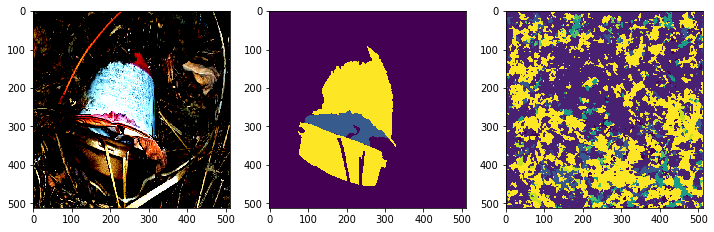

  0%|          | 0/328 [00:00<?, ?it/s]

1 / 20 : train_loss = nan, train_acc = 0.2008, valid_loss = 0.0935, valid_acc = 0.3327
save the model : dv3p_16batch_adamp_512_cos_cusloss.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


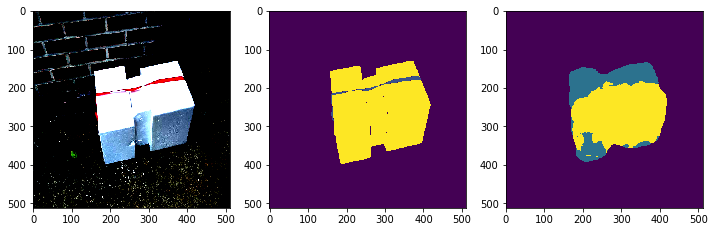

100%|██████████| 41/41 [00:36<00:00,  1.14it/s]


2 / 20 : train_loss = 0.4564, train_acc = 0.2883, valid_loss = 0.0908, valid_acc = 0.3403
save the model : dv3p_16batch_adamp_512_cos_cusloss.pt


  0%|          | 0/328 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


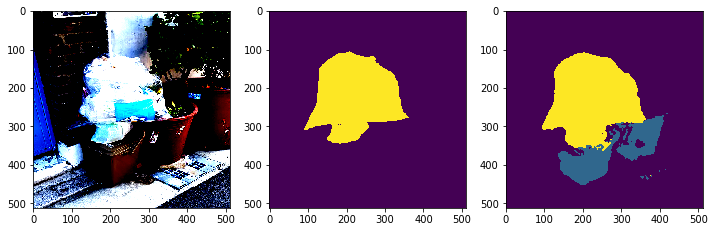

100%|██████████| 41/41 [00:36<00:00,  1.12it/s]


3 / 20 : train_loss = 0.4189, train_acc = 0.3374, valid_loss = 0.0884, valid_acc = 0.4060
save the model : dv3p_16batch_adamp_512_cos_cusloss.pt


  0%|          | 0/328 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


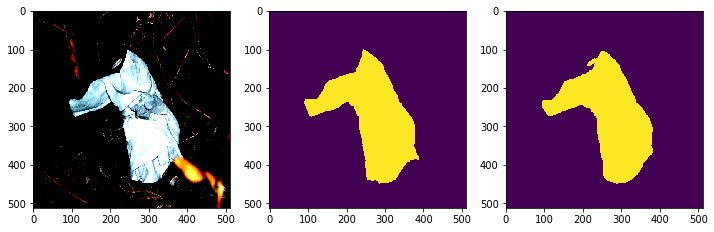

100%|██████████| 41/41 [00:36<00:00,  1.13it/s]


4 / 20 : train_loss = 0.3898, train_acc = 0.3951, valid_loss = 0.0885, valid_acc = 0.4300
save the model : dv3p_16batch_adamp_512_cos_cusloss.pt


  0%|          | 0/328 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


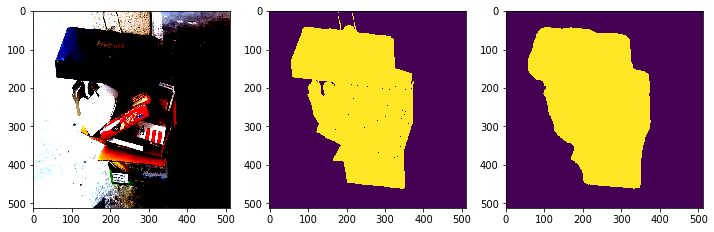

100%|██████████| 41/41 [00:36<00:00,  1.13it/s]


5 / 20 : train_loss = 0.3663, train_acc = 0.4490, valid_loss = 0.0882, valid_acc = 0.4403
save the model : dv3p_16batch_adamp_512_cos_cusloss.pt


  0%|          | 0/328 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


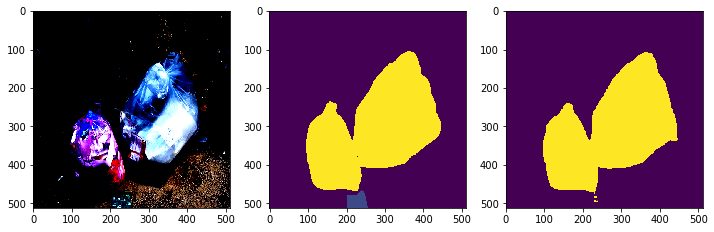

  0%|          | 0/328 [00:00<?, ?it/s]

6 / 20 : train_loss = 0.3509, train_acc = 0.4695, valid_loss = 0.0867, valid_acc = 0.4379


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


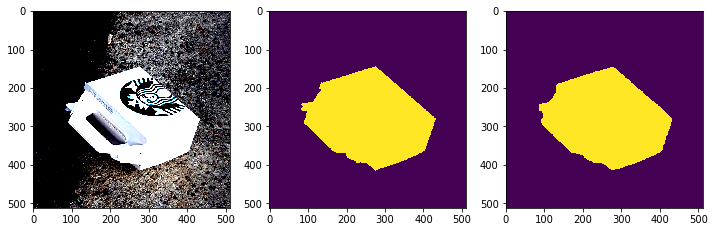

100%|██████████| 41/41 [00:36<00:00,  1.13it/s]


7 / 20 : train_loss = 0.3427, train_acc = 0.5017, valid_loss = 0.0858, valid_acc = 0.4631
save the model : dv3p_16batch_adamp_512_cos_cusloss.pt


  0%|          | 0/328 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


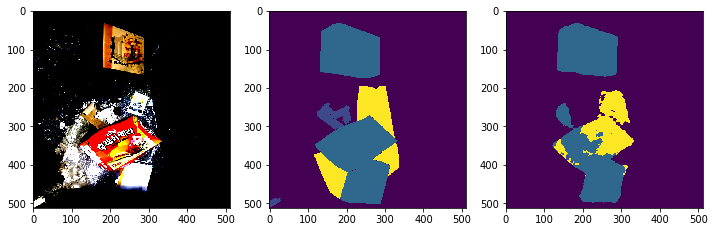

  0%|          | 0/328 [00:00<?, ?it/s]

8 / 20 : train_loss = 0.3304, train_acc = 0.5239, valid_loss = 0.0880, valid_acc = 0.4525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


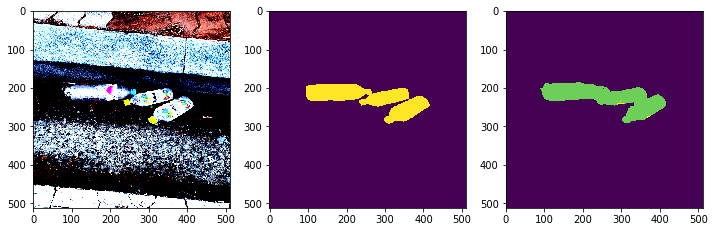

  0%|          | 0/328 [00:00<?, ?it/s]

9 / 20 : train_loss = 0.3242, train_acc = 0.5403, valid_loss = 0.0855, valid_acc = 0.4612


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


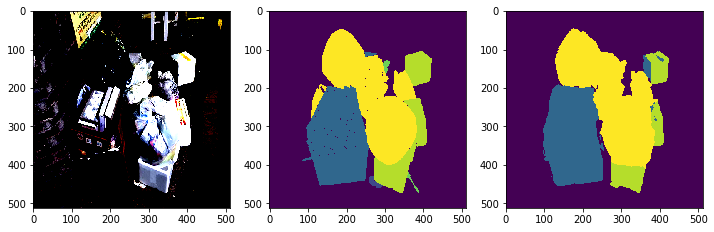

100%|██████████| 41/41 [00:36<00:00,  1.13it/s]


10 / 20 : train_loss = 0.3171, train_acc = 0.5608, valid_loss = 0.0841, valid_acc = 0.4893
save the model : dv3p_16batch_adamp_512_cos_cusloss.pt


  0%|          | 0/328 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


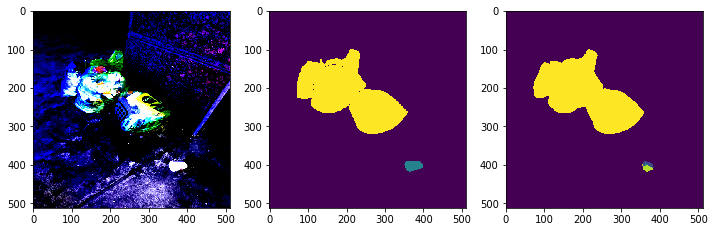

  0%|          | 0/328 [00:00<?, ?it/s]

11 / 20 : train_loss = 0.3001, train_acc = 0.5909, valid_loss = 0.0837, valid_acc = 0.4800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


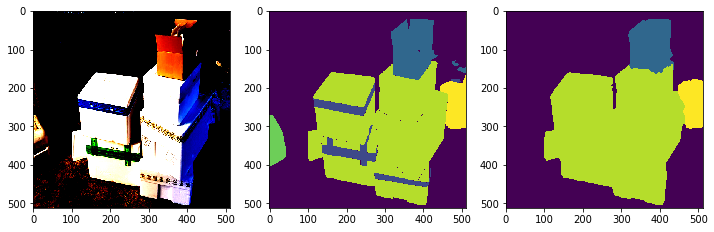

  0%|          | 0/328 [00:00<?, ?it/s]

12 / 20 : train_loss = 0.2964, train_acc = 0.5919, valid_loss = 0.0864, valid_acc = 0.4883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


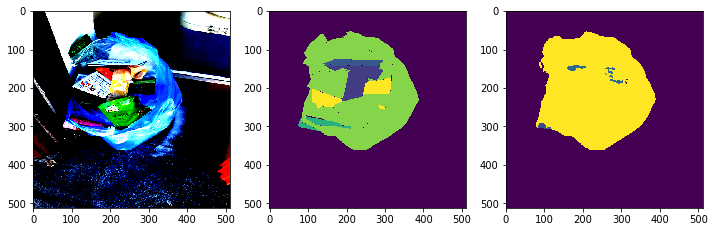

  0%|          | 0/328 [00:00<?, ?it/s]

13 / 20 : train_loss = 0.2923, train_acc = 0.5992, valid_loss = 0.0875, valid_acc = 0.4731


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


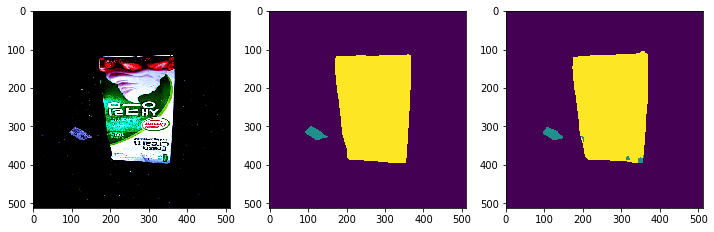

100%|██████████| 41/41 [00:35<00:00,  1.16it/s]


14 / 20 : train_loss = 0.2879, train_acc = 0.6203, valid_loss = 0.0836, valid_acc = 0.5048
save the model : dv3p_16batch_adamp_512_cos_cusloss.pt


  0%|          | 0/328 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


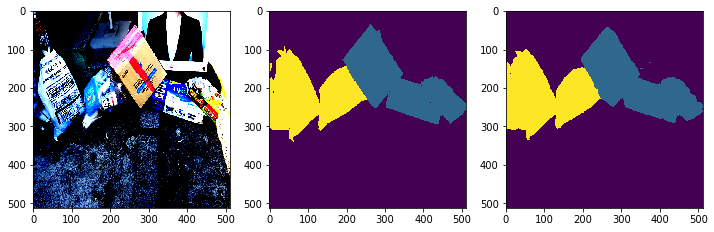

  0%|          | 0/328 [00:00<?, ?it/s]

15 / 20 : train_loss = 0.2866, train_acc = 0.6158, valid_loss = 0.0913, valid_acc = 0.4507


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


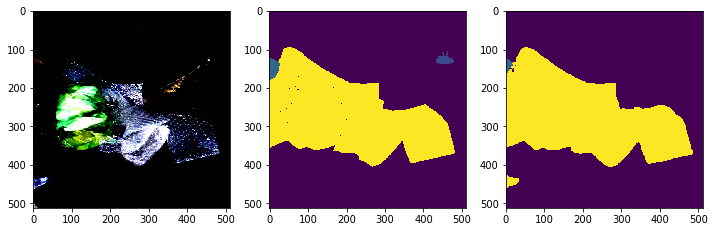

  0%|          | 0/328 [00:00<?, ?it/s]

16 / 20 : train_loss = 0.2820, train_acc = 0.6332, valid_loss = 0.0889, valid_acc = 0.4841


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


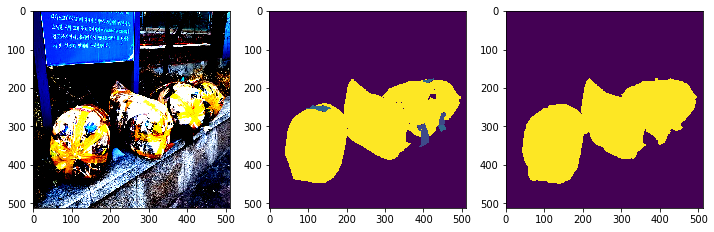

  0%|          | 0/328 [00:00<?, ?it/s]

17 / 20 : train_loss = 0.2889, train_acc = 0.6171, valid_loss = 0.0866, valid_acc = 0.5067


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


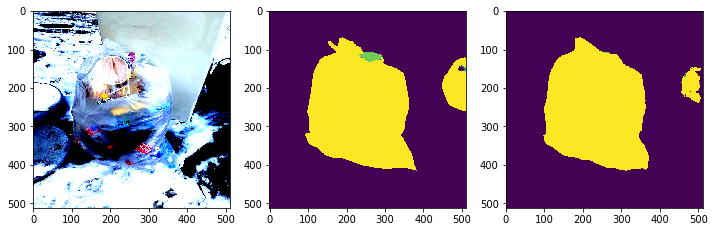

  0%|          | 0/328 [00:00<?, ?it/s]

18 / 20 : train_loss = 0.2805, train_acc = 0.6408, valid_loss = 0.0895, valid_acc = 0.4994


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


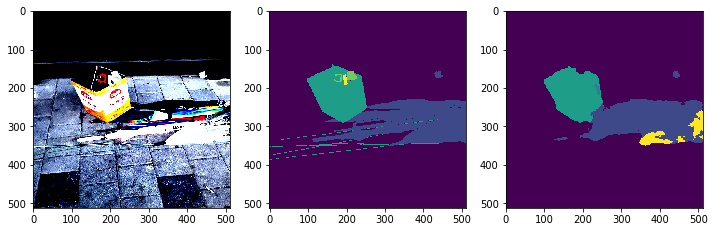

100%|██████████| 41/41 [00:34<00:00,  1.18it/s]


19 / 20 : train_loss = 0.2799, train_acc = 0.6604, valid_loss = 0.0893, valid_acc = 0.5188
save the model : dv3p_16batch_adamp_512_cos_cusloss.pt


  0%|          | 0/328 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


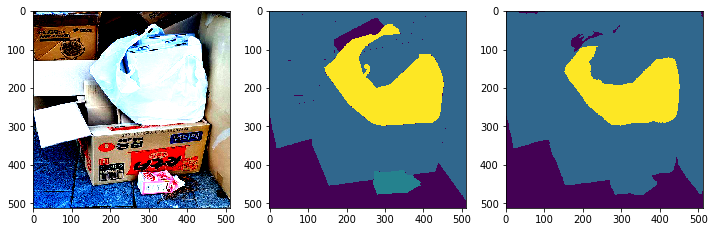

100%|██████████| 41/41 [00:35<00:00,  1.17it/s]


20 / 20 : train_loss = 0.2744, train_acc = 0.6860, valid_loss = 0.0863, valid_acc = 0.5540
save the model : dv3p_16batch_adamp_512_cos_cusloss.pt


In [5]:
n_epoch = 20
best_val_acc = -1
best_train_acc = -1

for epoch in range(n_epoch) :
    #학습
    isFirst = True
    model.train()
    train_loss = 0
    hist = np.zeros((class_nums, class_nums))
    for x, y, _ in tqdm(train_loader) :
        #x = torch.stack(x)       # (batch, channel, height, width)
        #y = torch.stack(y).long()  # (batch, channel, height, width)
        
        x_tmp = list()
        y_tmp = list()
        for i in range(len(x)) :
            for j in range(len(x[i])) :
                x_tmp.append(x[i][j])
                y_tmp.append(y[i][j])
        x = torch.stack(x_tmp)
        y = torch.stack(y_tmp).long()
        
        x, y = x.to(device), y.to(device)
        '''
        if x.shape[0] == 1 :
            x_clone = x.clone()
            x = (x, x_clone)
            x = torch.stack(x)
            y_clone = y.clone()
            y = (y, y_clone)
            y = torch.stack(y)
            x = x.reshape(2, 3, 256, 256)
            y = y.reshape(2, 256, 256)
        '''
        predict = model(x)#["out"]
        
        if isFirst :
            with torch.no_grad() :
                fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
                isFirst = False
                x_np = x[0].to('cpu').numpy()
                x_np = np.transpose(x_np, (1, 2, 0))
                ax1.imshow(x_np)
                ax2.imshow(y[0].to('cpu'))
                
                oms = torch.argmax(predict[0].squeeze(), dim=0).detach().cpu().numpy()                
                ax3.imshow(oms)#, cmap='jet')
                plt.show()
            
        
        #loss = criterion(predict, y)
        loss = CustomLoss(predict, y, device, 0.9, 0.1)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        predict = torch.argmax(predict, dim = 1).detach().cpu().numpy()
        #print(predict.shape)
        hist = add_hist(hist, y.detach().cpu().numpy(), predict, n_class = class_nums)
        
    _, _, train_miou, _ = label_accuracy_score(hist)
    train_loss = train_loss / len(train_loader)
    #테스트
    model.eval()
    valid_loss = 0
    with torch.no_grad() :
        hist = np.zeros((class_nums, class_nums))
        for x, y, _ in tqdm(val_loader) :
            x = torch.stack(x)
            y = torch.stack(y).long()
            x, y = x.to(device), y.to(device)
            
            if x.shape[0] == 1 :
                x_clone = x.clone()
                x = (x, x_clone)
                x = torch.stack(x)
                y_clone = y.clone()
                y = (y, y_clone)
                y = torch.stack(y)
                x = x.reshape(2, 3, 512, 512)
                y = y.reshape(2, 512, 512)

            predict = model(x)#["out"]
            
            loss = CustomLoss(predict, y, device, 0.9, 0.1)
            valid_loss += loss.item()
            
            predict = torch.argmax(predict, dim = 1).detach().cpu().numpy()
            #print(predict.shape)
            hist = add_hist(hist, y.detach().cpu().numpy(), predict, n_class = class_nums)

    _, _, valid_miou, _ = label_accuracy_score(hist)
    valid_loss = valid_loss / len(train_loader)
    
    print('{0} / {1} : train_loss = {2:.4f}, train_acc = {3:.4f}, valid_loss = {4:.4f}, valid_acc = {5:.4f}'.format(epoch+1, n_epoch, train_loss, train_miou, valid_loss, valid_miou))
    if train_miou > best_train_acc and valid_miou > best_val_acc :
        best_train_acc = train_miou
        best_val_acc = valid_miou
        model_name = 'dv3p_16batch_adamp_512_cos_cusloss.pt'
        print('save the model :', model_name)
        torch.save(model.state_dict(), model_name)
    else :
        if epoch == n_epoch - 1 :
            model_name = 'dv3p_16batch_adamp_512_cos_cusloss_full.pt'
            print('save the model :', model_name)
            torch.save(model.state_dict(), model_name)
        
    if train_loss < 0.05 : 
        #과적합 방지
        print('early stop')
        break
        
    scheduler.step(valid_miou)

In [ ]:
n_epoch = 5 #parameter
best_train_acc = best_val_acc
model.load_state_dict(torch.load('resnext_ela_aug_customLoss.pt'))
#model_name = 'resnext_ela_aug_customLoss.pt'

for epoch in range(n_epoch) :
    #학습
    isFirst = True
    model.train()
    train_loss = 0
    hist = np.zeros((class_nums, class_nums))
    for x, y, _ in tqdm(val_loader) :
        x = torch.stack(x)       # (batch, channel, height, width)
        y = torch.stack(y).long()  # (batch, channel, height, width)
        
        if x.shape[0] == 1 :
            x_clone = x.clone()
            x = (x, x_clone)
            x = torch.stack(x)
            y_clone = y.clone()
            y = (y, y_clone)
            y = torch.stack(y)
            x = x.reshape(2, 3, 512, 512)
            y = y.reshape(2, 512, 512)
            
        x, y = x.to(device), y.to(device)
        
        predict = model(x)#["out"]
        
        if isFirst :
            with torch.no_grad() :
                fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
                isFirst = False
                x_np = x[0].to('cpu').numpy()
                x_np = np.transpose(x_np, (1, 2, 0))
                ax1.imshow(x_np)
                ax2.imshow(y[0].to('cpu'))
                
                oms = torch.argmax(predict[0].squeeze(), dim=0).detach().cpu().numpy()                
                ax3.imshow(oms)#, cmap='jet')
                plt.show()
            
        
        #loss = criterion(predict, y)
        loss = CustomLoss(predict, y, device, 0.9, 0.1)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        predict = torch.argmax(predict, dim = 1).detach().cpu().numpy()
        #print(predict.shape)
        hist = add_hist(hist, y.detach().cpu().numpy(), predict, n_class = class_nums)
        
    _, _, train_miou, _ = label_accuracy_score(hist)
    train_loss = train_loss / len(train_loader)
    
    print('{0} / {1} : train_loss = {2:.4f}, train_acc = {3:.4f}'.format(epoch+1, n_epoch, train_loss, train_miou))
    if train_miou > best_train_acc :
        best_train_acc = train_miou
        model_name = 'resnext_ela_aug_customLoss+valid.pt'
        print('save the model :', model_name)
        torch.save(model.state_dict(), model_name)
        
    scheduler.step()

In [6]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    #file_list_
    preds_array = np.empty((0, size*size), dtype=np.long)
    #preds_own_array = np.empty((0, size*size), dtype = np.float)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in tqdm(enumerate(test_loader)):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))#['out']
            
            if outs.shape[0] == 1 : oms = torch.argmax(outs.squeeze(), dim = 0).detach().cpu().numpy()
            else : oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            #oms = oms.reshape(-1, 256, 256)
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

for model_name in ['dv3p_16batch_adamp_512_cos_cusloss.pt'] :#, 'dv3p_16batch_adamp_512_cos_full.pt'] :
    model.load_state_dict(torch.load(model_name))
    # sample_submisson.csv 열기
    submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)
    # test set에 대한 prediction
    file_names, preds = test(model, test_loader, device)
    # PredictionString 대입
    for file_name, string in zip(file_names, preds):
        submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                       ignore_index=True)
    # submission.csv로 저장
    submission.to_csv("./submission/"+model_name[:-3]+".csv", index=False)
    print(model_name[:-3], 'saved')
    #submission.to_csv("./submission_own/resnext_ela_aug_own.csv", index = False)
    

Start prediction.


53it [06:34,  7.44s/it]


End prediction.
dv3p_16batch_adamp_512_cos_cusloss saved


In [5]:
def multi_model_ensemble_test (models, dataloader, device) :
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    for model in models :
        model.eval()
    
    file_name_list = []
    #file_list_
    preds_array = np.empty((0, size*size), dtype=np.long)
    #preds_own_array = np.empty((0, size*size), dtype = np.float)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in tqdm(enumerate(test_loader)):
            x = torch.stack(imgs).to(device)

            # inference (512 x 512)
            outs = models[0](x)
            isFirst = True
            for model in models :
                if isFirst :
                    isFirst = False
                else :
                    outs += model(x)
            
            if outs.shape[0] == 1 : oms = torch.argmax(outs.squeeze(), dim = 0).detach().cpu().numpy()
            else : oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            #oms = oms.reshape(-1, 256, 256)
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array


device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
models = list()
dir_name = "./TOP3/"
for model_name in ["dv3p_16batch_adamp_512_cos.pt",\
                  "dv3p_16batch_adamp_512_full.pt",\
                  "dv3p_16batch_adamp_512.pt"] :
    model_name = dir_name + model_name
    model = smp.DeepLabV3Plus(
                encoder_name='resnext101_32x4d',
                encoder_weights = 'ssl',
                classes = class_nums).to(device)
    model.load_state_dict(torch.load(model_name))
    models.append(model)
    
model.load_state_dict(torch.load(model_name))
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)
# test set에 대한 prediction
file_names, preds = multi_model_ensemble_test(models, test_loader, device)
# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
save_name = "ensemble"
submission.to_csv("./submission/"+save_name+".csv", index=False)

Start prediction.


53it [07:34,  8.58s/it]


End prediction.
